# TensorFlow Addons Networks : Sequence-to-Sequence NMT with Attention Mechanism

**Reprise des commentaires sur https://blog.paperspace.com/seq-to-seq-attention-mechanism-keras/**

Code et tutoriel original ici: 

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/addons/blob/master/docs/tutorials/networks_seq2seq_nmt.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/addons/blob/master/docs/tutorials/networks_seq2seq_nmt.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
      <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/addons/docs/tutorials/networks_seq2seq_nmt.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview
This notebook gives a brief introduction into the ***Sequence to Sequence Model Architecture***
In this noteboook you broadly cover four essential topics necessary for Neural Machine Translation:


* **Data cleaning**
* **Data preparation**
* **Neural Translation Model with Attention**
* **Final Translation with ```tf.addons.seq2seq.BasicDecoder``` and ```tf.addons.seq2seq.BeamSearchDecoder```** 

The basic idea behind such a model though, is only the encoder-decoder architecture. These networks are usually used for a variety of tasks like text-summerization, Machine translation, Image Captioning, etc. This tutorial provideas a hands-on understanding of the concept, explaining the technical jargons wherever necessary. You focus on the task of Neural Machine Translation (NMT) which was the very first testbed for seq2seq models.


## Setup

Moi j'ai installé tf addons par `pip install tensorflow-addons==0.13.0` (ET NON PAS `conda install -c esri tensorflow-addons`). Voir les compatibilités [sur le github de tensorflow_addons](https://github.com/tensorflow/addons).

In [1]:
# !pip install tensorflow-addons==0.11.2

In [1]:
import sys
print(sys.version)

3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:36:06) [MSC v.1929 64 bit (AMD64)]


In [1]:
import tensorflow as tf
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

print(tf.__version__)

2.7.0


# Step 1: Import the DataSet

In [2]:
# Untar the dataset
# !unzip 'fra-eng.zip' # under linux

# Get the txt file which has English -> French translation
path_to_file  = './word2vec_docs_scol_traités/fra.txt'

# Step 2: Preprocess the data

The dataset has Unicode characters, which have to be normalized.

Moreover, all the tokens in the sequences have to be cleaned using the regular expressions library.

Remove unwanted spaces, include a space between every word and the punctuation following it (to differentiate between both), replace unwanted characters with spaces, and append `<start>` and `<end>` tokens to specify the start and end of a sequence.

Encapsulate the unicode conversion in a function `unicode_to_ascii()` and sequence preprocessing in a function preprocess_sentence().

## Data Cleaning and Data Preparation 

You'll use a language dataset provided by http://www.manythings.org/anki/. This dataset contains language translation pairs in the format:

---
      May I borrow this book?    ¿Puedo tomar prestado este libro?
---


There are a variety of languages available, but you'll use the English-Spanish dataset. After downloading the dataset, here are the steps you'll take to prepare the data:


1. Add a start and end token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a Vocabulary with word index (mapping from word → id) and reverse word index (mapping from id → word).
5. Pad each sentence to a maximum length. (Why? you need to fix the maximum length for the inputs to recurrent encoders)

In [4]:
import unicodedata

import re

# Convert the unicode sequence to ascii
def unicode_to_ascii(s):

  # Normalize the unicode string and remove the non-spacking mark
  return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

# Preprocess the sequence
def preprocess_sentence(w):
  # Clean the sequence
  w = unicode_to_ascii(w.lower().strip())

  # Create a space between word and the punctuation following it
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # Replace everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # Add a start and stop token to detect the start and end of the sequence
  w = '<start> ' + w + ' <end>'
  return w



phrases = io.open(path_to_file, encoding='UTF-8').read().strip().split('\n')


for phrase in phrases[:1]:
    print(preprocess_sentence(phrase), '\n')
    
[[preprocess_sentence(w) for w in l.split('\t')[:2]] for l in phrases[:5]]

<start> go . va ! cc by . france attribution tatoeba . org cm wittydev <end> 



[['<start> go . <end>', '<start> va ! <end>'],
 ['<start> go . <end>', '<start> marche . <end>'],
 ['<start> go . <end>', '<start> bouge ! <end>'],
 ['<start> hi . <end>', '<start> salut ! <end>'],
 ['<start> hi . <end>', '<start> salut . <end>']]

# Step 3: Prepare the DataSet

In [5]:
# Create the Dataset
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    # Loop through lines (sequences) and extract the English and French sequences. Store them as a word-pair
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t', 2)[:-1]]  for l in lines[:num_examples]]
    return zip(*word_pairs)

en, fra = create_dataset(path_to_file, 3)

In [6]:
print(type(en))
print(len(en))
print(en)
print(fra)

<class 'tuple'>
3
('<start> go . <end>', '<start> go . <end>', '<start> go . <end>')
('<start> va ! <end>', '<start> marche . <end>', '<start> bouge ! <end>')


Now tokenize the sequences. Tokenization is the mechanism of creating an internal vocabulary comprising English and French tokens (i.e. words), converting the tokens (or, in general, sequences) to integers, and padding them all to make the sequences possess the same length. All in all, tokenization facilitates the model training process.

Create a function `tokenize()` to encapsulate all the above-mentioned requirements.


In [7]:
# Convert sequences to tokenizers
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  
  # Convert sequences into internal vocab
  lang_tokenizer.fit_on_texts(lang)

  # Convert internal vocab to numbers
  tensor = lang_tokenizer.texts_to_sequences(lang)

  # Pad the tensors to assign equal length to all the sequences
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')

  return tensor, lang_tokenizer

Load the tokenized dataset by calling the `create_dataset()` and `tokenize()` functions.

In [8]:
# Load the dataset
def load_dataset(path, num_examples=None):
 
  # Create dataset (targ_lan = English, inp_lang = French)
  targ_lang, inp_lang = create_dataset(path, num_examples)
  # targ_lang, inp_lang are tuples, each containing the ordered sentences

  # Tokenize the sequences
  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

Reduce the number of data samples required to train the model. Employing the whole dataset will consume a lot more time for training the model.

In [9]:
# Consider 50k examples
num_examples = 10000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)
# inp_lang, targ_lang are tokenizers whose attribute index_word is a dictionary matching indices (keys: integers) to their corresponding words (values: string words)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [10]:
print("tenseur")
print(type(input_tensor))
print(np.shape(input_tensor))
input_tensor[0]
print("tokenizer")
print(type(inp_lang))
print(type(inp_lang.index_word))

tenseur
<class 'numpy.ndarray'>
(10000, 15)
tokenizer
<class 'keras_preprocessing.text.Tokenizer'>
<class 'dict'>


The `max_length` of both the input and target tensors is essential to determine every sequence's maximum padded length.
# Step 4: Create the Dataset

In [11]:
# !pip3 install sklearn

from sklearn.model_selection import train_test_split

# Create training and validation sets using an 80/20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

print(type(input_tensor_train), type(target_tensor_train))
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
8000 8000 2000 2000


Validate the mapping that’s been created between the tokens of the sequences and the indices. <br /> `inp_lang.index_word` is a dictionary whose keys are integers (indices of words) and values are strings (words of the vocabulary)

In [12]:
# Show the mapping b/w word index and language tokenizer
def convert(lang, tensor):
  for t in tensor: # t est un entier élément du tenseur
    if t != 0:
      print ("%d ----> %s" % (t, lang.index_word[t]))
      
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
24 ----> tu
31 ----> es
499 ----> idiote
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
6 ----> you
12 ----> re
335 ----> silly
3 ----> .
2 ----> <end>


# Step 5: Initialize the Model Parameters

With the dataset in hand, start initializing the model parameters.

* `BUFFER_SIZE`: Total number of input/target samples. In our model, it’s 40,000.
* `BATCH_SIZE`: Length of the training batch.
* `steps_per_epoch`: The number of steps per epoch. Computed by dividing BUFFER_SIZE by BATCH_SIZE.
* `embedding_dim`: Number of nodes in the embedding layer.
* `units: Hidden` units in the network.
* `vocab_inp_size`: Length of the input (French) vocabulary.
* `vocab_tar_size`: Length of the output (English) vocabulary.

In [13]:
# Essential model parameters
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE # = num_examples//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index) + 1 # pourquoi +1 ?
vocab_tar_size = len(targ_lang.word_index) + 1

Next, call the `tf.data.Dataset` API and create a proper dataset. <br /> Documentation if the `from_tensor_slices`: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices

The given tensors are sliced along their first dimension. This operation preserves the structure of the input tensors, removing the first dimension of each tensor and using it as the dataset dimension. All input tensors must have the same size in their first dimensions.

In [14]:
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

print(f"characteristics of dataset")
print(type(dataset), len(dataset))
dataset_iterator_list = list(dataset.as_numpy_iterator())

print("\ncharacteristics of list(dataset.as_numpy_iterator())")

print(type(dataset_iterator_list),len(dataset_iterator_list), "(= steps_per_epoch)")
print(type(dataset_iterator_list[0]), len(dataset_iterator_list[0])) 
print(type(dataset_iterator_list[0][0]), np.shape(dataset_iterator_list[0][0]), "(= BATCH_SIZE,max_length_inp)")

characteristics of dataset
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'> 125

characteristics of list(dataset.as_numpy_iterator())
<class 'list'> 125 (= steps_per_epoch)
<class 'tuple'> 2
<class 'numpy.ndarray'> (64, 15) (= BATCH_SIZE,max_length_inp)


Validate the shapes of the input and target batches of the newly-created dataset.

In [15]:
# Size of input and target batches
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 15]), TensorShape([64, 8]))

64 (first dimension) is the batch size
19 and 11 denote the maximum padded lengths of the input (French) and target (English) sequences.

# Step 6: Encoder Class

The first step in creating an encoder-decoder sequence-to-sequence model (with an attention mechanism) is creating an encoder. For the application at hand, create an encoder with an embedding layer followed by a GRU (Gated Recurrent Unit) layer. The input goes through the embedding layer first and then into the GRU layer. The GRU layer outputs both the encoder network output and the hidden state.

Enclose the model’s `__init__()` and `call()` methods in a class Encoder.

In the method, `__init__()`, initializes the batch size and encoding units. Add an embedding layer that accepts `vocab_size` as the input dimension and `embedding_dim` as the output dimension. Also, add a GRU layer that accepts units (dimensionality of the output space) and the first hidden dimension.

In the method `call()`, define the forward propagation that has to happen through the encoder network.

Moreover, define a method `initialize_hidden_state()` to initialize the hidden state with the dimensions `batch_size` and units.

Add the following code as part of your Encoder class.

In [16]:
# Encoder class
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units

    # Embed the vocab to a dense embedding 
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

    # GRU Layer
    # glorot_uniform: Initializer for the recurrent_kernel weights matrix, 
    # used for the linear transformation of the recurrent state
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  # Encoder network comprises an Embedding layer followed by a GRU layer
  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state=hidden)
    return output, state

  # To initialize the hidden state
  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

Call the encoder class to check the shapes of the encoder output and hidden state.

In [17]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

print ('Encoder Output       shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units)                  {}'.format(sample_hidden.shape))

Encoder Output       shape: (batch size, sequence length, units) (64, 15, 1024)
Encoder Hidden state shape: (batch size, units)                  (64, 1024)


In [ ]:
encoder.save('encoder.h5', save_format="tf")
# NotImplementedError

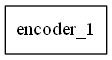

In [22]:
tf.keras.utils.plot_model(encoder, to_file='encoder.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96,
    layer_range=None, show_layer_activations=True
)


# Step 7: Attention Mechanism Class

This step captures the attention mechanism.

* Compute the sum (or product) of the encoder’s outputs and decoder states.
* Pass the generated output through a fully-connected network.
* Apply softmax activation to the output. This gives the attention weights.
* Create the context vector by computing the weighted sum of attention weights and encoder’s outputs.

Everything thus far needs to be captured in a class `BahdanauAttention`. **Bahdanau Attention** is also called the **“Additive Attention”**, a **Soft Attention** technique. As this is additive attention, we do the sum of the encoder’s outputs and decoder hidden state (as mentioned in the first step).

This class has to have `__init__()` and `call()` methods.

- In the `__init__()` method, initialize three Dense layers: one for the decoder state ('units' is the size), another for the encoder’s outputs ('units' is the size), and the other for the fully-connected network (one node).

- In the `call()` method, initialize the decoder state ($s_0$) by taking the final encoder hidden state. Pass the generated decoder hidden state through one dense layer. Also, plug the encoder’s outputs through the other dense layer. Add both the outputs, encase them in a $\tanh$ activation and plug them into the fully-connected layer. This fully-connected layer has one node; thus, the final output has the dimensions `batch_size * max_length of the sequence * 1`.

Later, apply $\text{softmax}$ on the output of the fully-connected network to generate the attention weights.

Compute the `context_vector` by performing a weighted sum of the attention weights and the encoder’s outputs.

In [17]:
# Attention Mechanism
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # values shape == (batch_size, max_len, hidden size)

    # we are doing this to broadcast addition along the time axis to calculate the score
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

Validate the shapes of the Attention weights and its output.
`sample_hidden` here is the hidden state of the encoder, and `sample_output` denotes the encoder’s outputs.

In [18]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 19, 1)


# Step 8: Decoder Class

This step encapsulates the decoding mechanism. The Decoder class has to have two methods: `__init__()` and `call()`.

In the `__init__()` method, initialize the batch size, decoder units, embedding dimension, GRU layer, and a Dense layer. Also, create an instance of the `BahdanauAttention` class.

In the `call()` method:

* Call the attention forward propagation and capture the context vector and attention weights.
* Send the target token through an embedding layer.
* Concatenate the embedded output and context vector.
* Plug the output into the GRU layer and then into a fully-connected layer.

In [19]:
# Decoder class
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # Used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # x shape == (batch_size, 1)
    # hidden shape == (batch_size, max_length)
    # enc_output shape == (batch_size, max_length, hidden_size)

    # context_vector shape == (batch_size, hidden_size)
    # attention_weights shape == (batch_size, max_length, 1)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

Validate the decoder output shape

In [20]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 5938)


In [21]:
encoder.summary()
decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  2608640   
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
Total params: 6,546,944
Trainable params: 6,546,944
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  1520128   
                                                                 
 gru_1 (GRU)                 multiple                  7084032   
                                                                 
 dense_3 (Dense)             mul

# Step 9: Define the optimizer and the loss function
Define the optimizer and loss functions.

As the input sequences are being padded with zeros, nullify the loss when there’s a zero in the `real` value.

In [22]:
# Initialize optimizer and loss functions
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# Loss function
def loss_function(real, pred):

  # Take care of the padding. Not all sequences are of equal length.
  # If there's a '0' in the sequence, the loss is being nullified
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

# Step 10: Train the Model
Checkpoint your model’s weights during training. This helps in the automatic retrieval of the weights while evaluating the model.

In [23]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,encoder=encoder,decoder=decoder)

Next, define the training procedure. First, call the encoder class and procure the encoder outputs and final hidden state. Initialize the decoder input to have the `<start>` token spread across all the input sequences (indicated using the `BATCH_SIZE`). Use the teacher forcing technique to iterate over all decoder states by feeding the target as the next input. This loop continues until every token in the target sequence (English) is visited.

Call the decoder class with decoder input, decoder hidden state, and encoder’s outputs. Procure the decoder output and hidden state. Compute the loss by comparing the real against the predicted value of the target. Fetch the target token and feed it to the next decoder state (concerning the successive target token). Also, make a note that the target decoder hidden state will be the next decoder hidden state.

After the teacher forcing technique gets finished, compute the batch loss, and run the optimizer to update the model's variables.

In [24]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  # tf.GradientTape() -- record operations for automatic differentiation
  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    # dec_hidden is used by attention, hence is the same enc_hidden
    dec_hidden = enc_hidden

    # <start> token is the initial decoder input
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):

      # Pass enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      # Compute the loss
      loss += loss_function(targ[:, t], predictions)

      # Use teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  # As this function is called per batch, compute the batch_loss
  batch_loss = (loss / int(targ.shape[1]))

  # Get the model's variables
  variables = encoder.trainable_variables + decoder.trainable_variables

  # Compute the gradients
  gradients = tape.gradient(loss, variables)

  # Update the variables of the model/network
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

Now initialize the actual training loop. Run your loop over a specified number of epochs. First, initialize the encoder hidden state using the method `initialize_hidden_state()`. Loop through the dataset one batch at a time (per epoch). Call the `train_step()` method per batch and compute the loss. Continue until all the epochs have been covered.

In [25]:
import time

EPOCHS = 5

# Training loop
for epoch in range(EPOCHS):
  start = time.time()

  # Initialize the hidden state
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  # Loop through the dataset
  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):

    # Call the train method
    batch_loss = train_step(inp, targ, enc_hidden)

    # Compute the loss (per batch)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # Save (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  # Output the loss observed until that epoch
  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.7148
Epoch 1 Batch 100 Loss 2.1596
Epoch 1 Batch 200 Loss 1.8383
Epoch 1 Batch 300 Loss 1.7680
Epoch 1 Batch 400 Loss 1.5964
Epoch 1 Batch 500 Loss 1.6257
Epoch 1 Batch 600 Loss 1.5310
Epoch 1 Loss 1.8884
Time taken for 1 epoch 122.8930013179779 sec

Epoch 2 Batch 0 Loss 1.5565
Epoch 2 Batch 100 Loss 1.4449
Epoch 2 Batch 200 Loss 1.4419
Epoch 2 Batch 300 Loss 1.4422
Epoch 2 Batch 400 Loss 1.3437
Epoch 2 Batch 500 Loss 1.2759
Epoch 2 Batch 600 Loss 1.3462


# Step 11: Test the Model
## Use tf-addons BasicDecoder for decoding

Now define your model evaluation procedure. First, take the sentence given by the user into consideration. This has to be given in the French language. The model now has to convert the sentence from French to English.

Initialize an empty attention plot to be plotted later on with `max_length_target` on the Y-axis, and max_length_input on the X-axis.

Preprocess the sentence and convert it into tensors.

Then plug the sentence into the model.

Initialize an empty hidden state which is to be used while initializing an encoder. Usually, the `initialize_hidden_state()` method in the encoder class gives the hidden state having the dimensions `batch_size * hidden_units`. Now, as the batch size is 1, the initial hidden state has to be manually initialized.

Call the encoder class and procure the encoder outputs and final hidden state.

By looping over `max_length_targ`, call the decoder class wherein the `dec_input` is the `<start>` token, `dec_hidden` state is the encoder hidden state, and `enc_out` is the encoder’s outputs. Procure the decoder output, hidden state, and attention weights.

Create a plot using the attention weights. Fetch the predicted token with the maximum attention. Append the token to the result and continue until the `<end>` token is reached.

The next decoder input will be the previously predicted index (concerning the token).

Add the following code as part of the `evaluate()` function.

In [ ]:

# Evaluate function -- similar to the training loop
def evaluate(sentence):

  # Attention plot (to be plotted later on) -- initialized with max_lengths of both target and input
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  # Preprocess the sentence given
  sentence = preprocess_sentence(sentence)

  # Fetch the indices concerning the words in the sentence and pad the sequence
  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  # Convert the inputs to tensors
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  # Loop until the max_length is reached for the target lang (ENGLISH)
  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # Store the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    # Get the prediction with the maximum attention
    predicted_id = tf.argmax(predictions[0]).numpy()

    # Append the token to the result
    result += targ_lang.index_word[predicted_id] + ' '

    # If <end> token is reached, return the result, input, and attention plot
    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # The predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

# Step 12: Plot and Predict

Define the `plot_attention()` function to plot the attention statistics.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

Define a function `translate()` which internally calls the `evaluate()` function.

In [ ]:
# Translate function (which internally calls the evaluate function)
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Restore the saved checkpoint to the model.

In [ ]:
# Restore the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> ou es tu maintenant <end>
Predicted translation: are we ready ? <end> 


C:\Users\matth\AppData\Local\Temp/ipykernel_11340/124968884.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\matth\AppData\Local\Temp/ipykernel_11340/124968884.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


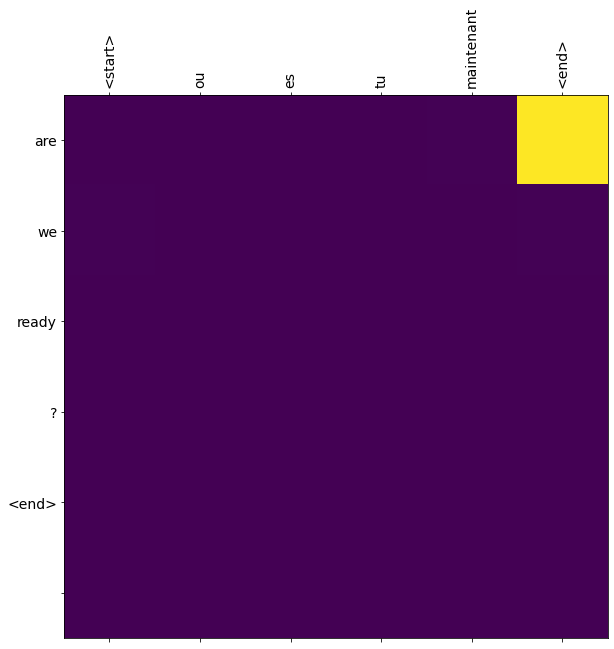

In [ ]:
translate(u"ou es tu maintenant ?")